In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, PrecisionRecallDisplay, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import pickle


In [19]:
# Загрузка данных Титаника
df = pd.read_csv('Titanic-Dataset.csv')
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]
df = df.dropna(subset=['Age'])


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Pclass    714 non-null    int64  
 2   Sex       714 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      714 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 33.5+ KB


In [ ]:
#Данные на вход модели
df.drop('Survived', axis =1)


,Pclass,Sex,Age,Fare
0,3,male,22.0,7.2500
1,1,female,38.0,71.2833
2,3,female,26.0,7.9250
3,1,female,35.0,53.1000
4,3,male,35.0,8.0500
...,...,...,...,...
885,3,female,39.0,29.1250
886,2,male,27.0,13.0000
887,1,female,19.0,30.0000
889,1,male,26.0,30.0000


In [ ]:
# Разделим на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.3, random_state=1, stratify=df['Survived'])


In [ ]:
train['Survived'].value_counts(normalize = True)


Survived
0    0.593186
1    0.406814
Name: proportion, dtype: float64

In [ ]:
test['Survived'].value_counts(normalize = True)


Survived
0    0.595349
1    0.404651
Name: proportion, dtype: float64

In [ ]:
train.select_dtypes(include='category').columns


Index([], dtype='object')

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Pclass    714 non-null    int64  
 2   Sex       714 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      714 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 33.5+ KB


In [77]:
def experiment(target):
    # Создание и обучение модели
    cat_features = list(train.select_dtypes(include=['object','category']).columns)
    model = CatBoostClassifier(cat_features=cat_features, verbose=300)
    model.fit(train.drop(target, axis=1), train[target])

    # Вычисление метрик
    preds = model.predict(test.drop(target, axis=1))
    f1 = f1_score(test[target], preds)

    # Визуализация матрицы ошибок
    cm = ConfusionMatrixDisplay.from_predictions(test[target], preds)

    # Вывод сводной инфы о метриках
    print(classification_report(test[target], preds))
    print(f'f_score: {round(f1,2)}')

    # PR, Recall кривая
    PrecisionRecallDisplay.from_estimator(model, test.drop(target, axis=1), test[target])
    plt.title("Precision-Recall кривая")
    plt.grid(True)
    plt.show()

    # ROC_AUC кривая
    RocCurveDisplay.from_estimator(model, test.drop(target, axis=1), test[target])
    plt.title("Roc-Auc кривая")
    plt.grid(True)
    plt.show()

    # Сохранение модели в формате pickle
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)


Learning rate set to 0.007656
0:	learn: 0.6882827	total: 1.98ms	remaining: 1.98s
300:	learn: 0.3628905	total: 143ms	remaining: 332ms
600:	learn: 0.3200045	total: 280ms	remaining: 186ms
900:	learn: 0.2842534	total: 429ms	remaining: 47.2ms
999:	learn: 0.2710903	total: 482ms	remaining: 0us
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       128
           1       0.81      0.63      0.71        87

    accuracy                           0.79       215
   macro avg       0.80      0.77      0.77       215
weighted avg       0.79      0.79      0.79       215

f_score: 0.71


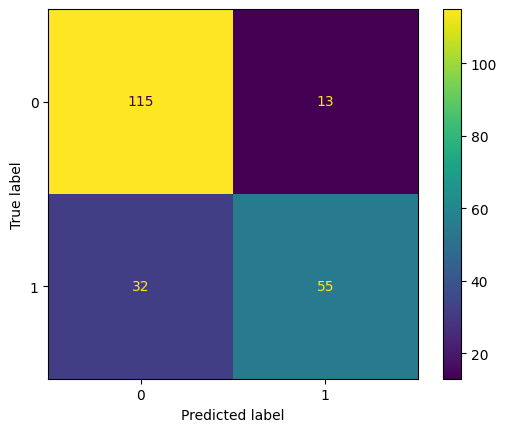

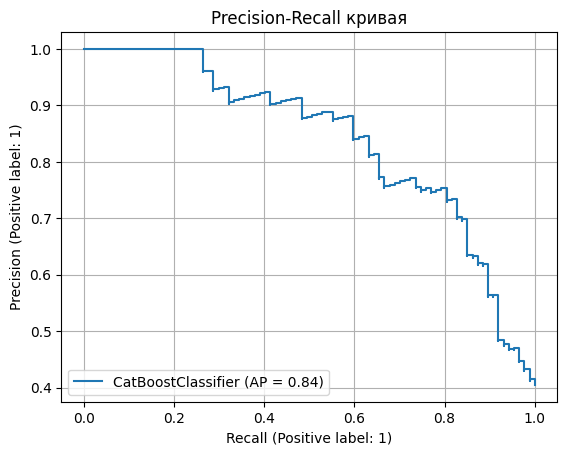

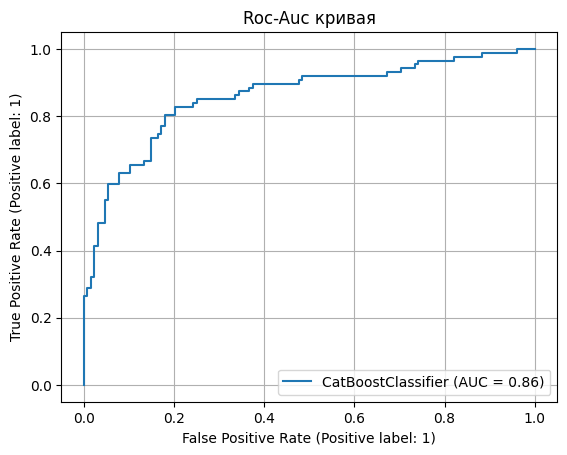

In [ ]:
#Запускам обучение
experiment(target='Survived')


In [3]:
#Загрузка модели из файла pickle
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)


In [4]:
new_data = pd.DataFrame({
    'Pclass' : [3],
    'Sex'    : ['female'],
    'Age'    : [5.0],
    'Fare'   : [7]
})


In [5]:
# Предсказание
predictions = model.predict(new_data)

#Вывод результата
print('Predicted Survival:', predictions)


Predicted Survival: [1]


## Test API

In [33]:
import requests # чтобы отправлять HTTP-запросы из Python

def predict_model(data):
    url = 'http://127.0.0.1:500/predict_model' #адрес FastAPI-сервера и путь до эндпоинта /predict_model

    # Отправка POST-запроса с данными в формате форм-данных
    response = requests.post(url,       # куда отправить
                             json=data) # что отправить (тело запроса в формате JSON)

    # Проверка статуса ответа
    if response.status_code == 200:
        return response.json()
    else:
        return {"error" : f"Request failed with status code {response.status_code}"}

    # Пример данных для предсказания

data = {
    "Pclass" : 1,
    "Sex"    : "male",
    "Age"    : 5.0,
    "Fare"   : 7000
}

#Получения предсказания
prediction = predict_model(data)
print(prediction)


{'prediction': 'Survived'}
